## Required Imports and Helper functions taken from the coursera project

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import keras
print(keras.backend.backend())

Using TensorFlow backend.


tensorflow


In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

False

In [4]:

from tensorflow.python.client import device_lib
def get_available_devices():
    local_devices_photo=device_lib.list_local_devices()
    return [x.name for x in local_devices_photo]
print (get_available_devices())

['/device:CPU:0']


In [4]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
from pydub.playback import play
import librosa as lr

# Calculate and plot spectrogram for a wav audio file

# Load a wav file
def get_wav_info(wav_file):
    data, rate = lr.load(path=wav_file,sr=44100)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft =  200#of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins,im= plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins,im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx,freqs,bins

def load_raw_audio():
    positives = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("positives"):
        if filename.endswith("wav"):
            positive = AudioSegment.from_wav("positives/"+filename)
            positives.append(positive)
    for filename in os.listdir("backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("backgrounds/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("negatives/"+filename)
            negatives.append(negative)
    return positives,negatives, backgrounds

c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\pydub\utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


In [5]:
import IPython.display as ipd
#ipd.Audio("positives/1.wav")
#ipd.Audio("negatives/1.wav")
#ipd.Audio("backgrounds_before_processing/white_noise.wav")

### Converting the background noises to 10s clips

In [6]:
ac_noise=AudioSegment.from_wav("backgrounds_before_processing/ac_noise.wav")

In [7]:
time=10*1000
ac_noise_clipped=ac_noise[:time]

In [8]:
ac_noise_clipped.export("backgrounds/ac_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds/ac_noise_clipped.wav'>

In [9]:
pink_noise=AudioSegment.from_wav("backgrounds_before_processing/pink_noise.wav")

In [10]:
pink_noise_clipped=pink_noise[:time]

In [11]:
pink_noise_clipped.export("backgrounds/pink_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds/pink_noise_clipped.wav'>

In [12]:
white_noise=AudioSegment.from_wav("backgrounds_before_processing/white_noise.wav")

In [13]:
white_noise_clipped=white_noise[:time]

In [14]:
white_noise_clipped.export("backgrounds_before_processing/white_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds_before_processing/white_noise_clipped.wav'>

In [15]:
doing_the_dishes_noise=AudioSegment.from_wav("backgrounds_before_processing/doing_the_dishes_noise.wav")

In [16]:
doing_the_dishes_noise_clipped=doing_the_dishes_noise[:time]

In [17]:
doing_the_dishes_noise_clipped.export("backgrounds/doing_the_dishes_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds/doing_the_dishes_noise_clipped.wav'>

# The original sampling rates for the noises are:
ac_noise=> 48000
doing_the_dishes_noise=>16000
pink_noise=>16000
white_noise=>16000

In [18]:
rate,audio=get_wav_info("backgrounds_before_processing/white_noise.wav")

In [19]:
rate,audio.shape

(44100, (2646000,))

there is a small confusion! the audio part of the ac_noise read using wavfile.read from scipy gives a two dimensional array but if its read using librosa that problem is done, still the no of samples in the ac_noise and ac_noise_clipped is different

In [20]:
rate,audio=get_wav_info("backgrounds_before_processing/ac_noise.wav")

In [21]:
audio.shape,rate

((572948,), 44100)

###          







### Checking if the clipping is proper and analysing various rates and audio files

In [22]:
rate1,audio1=get_wav_info("negatives/1.wav")

In [23]:
print(rate1,audio1.shape)

44100 (44100,)


## Now all the audio files are ready to be used, you can get the rate and the audio array by just calling the function get_wav_info

In [24]:
rate3,audio3=get_wav_info("positives/2.wav")

In [25]:
print(rate3,audio3.shape)

44100 (20479,)


(101, 254)
(101,)
(254,)


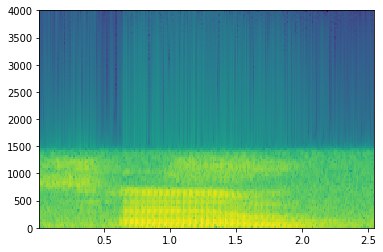

In [26]:
f,g,h=graph_spectrogram("positives/2.wav")
print(f.shape)
print(g.shape)
print(h.shape)


# Starting to build the training dataset

In [27]:
#activates, negatives, backgrounds 
positives,negatives,backgrounds= load_raw_audio()

In [28]:
#for audio in negatives:
   # play(audio)

In [29]:
print("background_len:",len(backgrounds[3]))
print("activates_len:",len(positives[11]))
print("negative_len:",len(negatives[2]))

background_len: 10000
activates_len: 464
negative_len: 811


# Helper functions needed to prepare the dataset
1. get_random_time_segment(segment_ms) gets a random time segment in our background audio
2. is_overlapping(segment_time, existing_segments) checks if a time segment overlaps with existing segments
3. insert_audio_clip(background, audio_clip, existing_times) inserts an audio segment at a random time in our background audio 4. using get_random_time_segment and is_overlapping
5. insert_ones(y, segment_end_ms) inserts 1's into our label vector y after the word "activate"

In [30]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [31]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###

    return overlap

In [32]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [33]:

audio_clip, segment_time = insert_audio_clip(backgrounds[0], positives[16], [(3790, 4400)])

print("Segment Time: ", segment_time)
#play(audio_clip)

Segment Time:  (7998, 8328)


In [34]:
Ty=1375
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y


In [35]:
def create_training_example(background, positives, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    #np.random.seed(18)
    Ty=1375
    # Make background quieter
    background = background - 40
    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_positives = np.random.randint(0, 4)
    random_indices = np.random.randint(len(positives), size=number_of_positives)
    random_positives = [positives[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_positive in random_positives:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_positive, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 4)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
        
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
   # print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x,freqs,bins = graph_spectrogram("train.wav")
    
    return x,y,background

# Let *Tx* be the no of timesteps fed to model from the spectrogram and *Ty* be the no of timesteps in the output given by the model to be built
Tx=5511
Ty=1375

In [36]:
#play(backgrounds[0])

c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:7725: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(1, 1375)


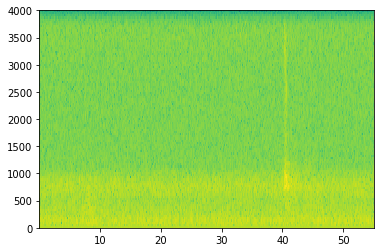

In [37]:
x2,y2,back=create_training_example(backgrounds[0], positives, negatives)
np.transpose(x2).shape
play(back)
print(y2.shape)

In [38]:
np.set_printoptions(threshold=np.inf)

In [39]:

#print(y2[0][610:])
#play(z2)
#print(p2)

# the task here onwards is to verify that the labels are correct and then we can start building the model.

# all the labels are correct, now lets build a dataset

In [40]:
#x_train=[]
#y_train=[]
#audio_sample=[]
#for i in range(1500):
#    x,y,z=create_training_example(backgrounds[0], positives, negatives)
#    x_train.append(np.transpose(x))
#    y_train.append(np.transpose(y))
#    if(i%10==0):
#        print(i)
#    audio_sample.append(z)
#np.save("x_train.npy",x_train)
#np.save("y_train.npy",y_train)
#np.save("audio_sample",audio_sample)

In [41]:
#play(audio_sample[1])


In [42]:
#for i in range(10):
#    audio_sample[i].export("sample"+str(i)+".wav",format="wav")

In [43]:
#rate,audio=get_wav_info("op.wav")
#print(rate)

In [44]:
#play(audio_training[98])

In [45]:
x_train=np.load("x_sample.npy")
y_train=np.load("y_sample.npy")

In [46]:
print(x_train[0].shape)
print(y_train[0].shape)


(5511, 101)
(1375, 1)


In [47]:
import keras
print(keras.__version__)

2.2.4


In [48]:
from keras import backend as k
k.tensorflow_backend._get_available_gpus()

W0905 14:07:19.579767 10164 deprecation_wrapper.py:119] From c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0905 14:07:19.581768 10164 deprecation_wrapper.py:119] From c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0905 14:07:19.582768 10164 deprecation_wrapper.py:119] From c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0905 14:07:19.700970 10164 deprecation_wrapper.py:119] From c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables 

[]

In [49]:
#import keras
#config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
#sess = tf.Session(config=config) 
#keras.backend.set_session(sess)

# model building

In [107]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model,load_model,Sequential
from keras.layers import Dense,Activation,Dropout,Input,Masking,TimeDistributed,LSTM,Conv1D
from keras.layers import GRU,Bidirectional,BatchNormalization,Reshape
from keras.optimizers import Adam
def model(input_shape):
    X_input=Input(shape=input_shape)
    X=Conv1D(196,kernel_size=15,strides=4)(X_input)
   # X = BatchNormalization()(X)      
    X = Activation('relu')(X) 
   # X = Dropout(0.8)(X)  
    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X) # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
   # X = BatchNormalization()(X)     # Batch normalization
    # Step 3: Second GRU Layer (≈4 lines)
    #X = GRU(units = 128, return_sequences = True)(X)   # GRU (use 128 units and return the sequences)
    #X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    #X = BatchNormalization()(X)                                  # Batch normalization
    #X = Dropout(0.8)(X)                                  # dropout (use 0.8)
   
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    model = Model(inputs = X_input, outputs = X)
    return model

In [108]:
model = model(input_shape = (5511, 101))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
activation_2 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1375, 128)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1375, 1)           129       
Total params: 422,065
Trainable params: 422,065
Non-trainable params: 0
_________________________________________________________________


In [109]:
from sklearn.metrics import f1_score

In [110]:
model3=load_model("weights_best.hdf5")

In [111]:
pred=model3.predict(x_testing).round()
print(pred.shape)
print(y_testing.shape)
sum=0
print(len(y_testing))
for i in range(4):
    score=f1_score(y_testing[i],pred[i])
    sum+=score
print(sum/4)

(4, 1375, 1)
(4, 1375, 1)
4
0.0


c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [112]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.score_1=0
        
    def on_epoch_end(self,epoch,logs={}):
            validation_data_x=self.validation_data[0]
            y_true=self.validation_data[1]
            y_pred=self.model.predict(validation_data_x).round()
            sum=0
            for i in range(len(y_true)):
                sum+=f1_score(y_true[i],y_pred[i])
            sum=sum/len(y_true)
            self.score_2=sum
            if self.score_2>self.score_1:
                self.score_1=self.score_2
                print("score_2",self.score_2)
                model.save("the_best.hdf5")
            return

In [113]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
#adding checkpoint
filepath="weights_best.hdf5"
#checkpoint=ModelCheckpoint(filepath,monitor="val_acc",save_best_only=True,mode="auto",verbose=1)
#callbacks_list=[checkpoint]
callbacks_list=[Metrics()]

In [114]:
from sklearn.model_selection import train_test_split
x_training,x_testing,y_training,y_testing=train_test_split(x_train,y_train,test_size=0.33,random_state=42)
np.save("x_testing",x_testing)
np.save("y_testing",y_testing)
x_testing=np.load("x_testing.npy")
y_testing=np.load("y_testing.npy")


In [115]:
import time
start=time.time()
print(start)
model.fit(x_training, y_training, batch_size = 5, epochs=5,verbose=1,callbacks=callbacks_list,validation_data=(x_testing,y_testing))
end=time.time()
print(end-start)

1567684300.4822433
Train on 6 samples, validate on 4 samples
Epoch 1/5
6/6 [==============================] - 11s 2s/step - loss: 0.6930 - acc: 0.8537 - val_loss: 0.6909 - val_acc: 0.9727


c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Epoch 2/5
6/6 [==============================] - 7s 1s/step - loss: 0.6908 - acc: 0.9636 - val_loss: 0.6887 - val_acc: 0.9727
Epoch 3/5
6/6 [==============================] - 6s 1s/step - loss: 0.6886 - acc: 0.9636 - val_loss: 0.6863 - val_acc: 0.9727
Epoch 4/5
6/6 [==============================] - 7s 1s/step - loss: 0.6863 - acc: 0.9636 - val_loss: 0.6840 - val_acc: 0.9727
Epoch 5/5
6/6 [==============================] - 6s 1s/step - loss: 0.6839 - acc: 0.9636 - val_loss: 0.6815 - val_acc: 0.9727
45.23756980895996


In [67]:
#484.4966344833374--gpu 0
#170.46423602104187--cp -1
#502          --normal
#493            --gpu "0,2"
#493.69      -gpu "2"
#493           --gpu "1"
# 492             --gpu "3"

# first training - 100 examples 100 epochs 0.8506 accuracy loss - 0.5591930794715881 most predictions were having probability of 0.39...
# second training- 1000 examples 1000 epochs 

# Evaluate the model

In [47]:
loss, acc = model.evaluate(x_train, y_train)
print("Dev set accuracy = ", acc,loss)

5/5 [==============================] - 2s 318ms/step
Dev set accuracy =  0.9458909034729004 0.5650323033332825


# Making predictions

In [54]:

def detect_triggerword(i):
    #plt.subplot(2, 1, 1)

    #x,y,z = graph_spectrogram(filename)
    
    #x  = x.swapaxes(0,1)
    x=x_train[i]
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
   # plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [47]:
loss, acc = model.evaluate(x_train, y_train)
print("Dev set accuracy = ", acc,loss)

5/5 [==============================] - 2s 318ms/step
Dev set accuracy =  0.9458909034729004 0.5650323033332825


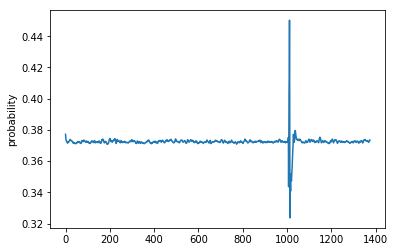

array([[[0.37715948],
        [0.37496638],
        [0.37381577],
        [0.37309074],
        [0.37308955],
        [0.37268403],
        [0.3722142 ],
        [0.37216687],
        [0.37180614],
        [0.37150276],
        [0.37188286],
        [0.37216026],
        [0.3721714 ],
        [0.3720047 ],
        [0.37224644],
        [0.37241593],
        [0.37261766],
        [0.37304276],
        [0.37314445],
        [0.37338296],
        [0.37384292],
        [0.3738704 ],
        [0.37384248],
        [0.37354356],
        [0.3733285 ],
        [0.3731954 ],
        [0.37287375],
        [0.37292385],
        [0.3729148 ],
        [0.37290034],
        [0.372749  ],
        [0.3725866 ],
        [0.37246832],
        [0.37179235],
        [0.37195837],
        [0.37191042],
        [0.3715615 ],
        [0.3716448 ],
        [0.37177235],
        [0.37153864],
        [0.37165606],
        [0.3713088 ],
        [0.3712982 ],
        [0.37135386],
        [0.37128052],
        [0

In [55]:
detect_triggerword(4)

In [51]:
print (x.shape,y.shape,z.shape)

NameError: name 'x' is not defined

In [57]:
model.save("smu.HDf5")